### OpenCV Project
- Resnet18 모델로 피자인지 아닌지 구별하는 전이학습한 모델

- 라자냐 => 낫피자로 수정 : 라자냐 210개, 낫피자 945개, 피자 945개

In [127]:
# Load Module
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torchinfo import summary
from torchmetrics.functional.classification import multiclass_accuracy

In [97]:
# 1. Load Data
file_dir = '../imgs'
not_pizza_dir = '../imgs/not_pizza/'
pizza_dir = '../imgs/pizza'

출력 테스트

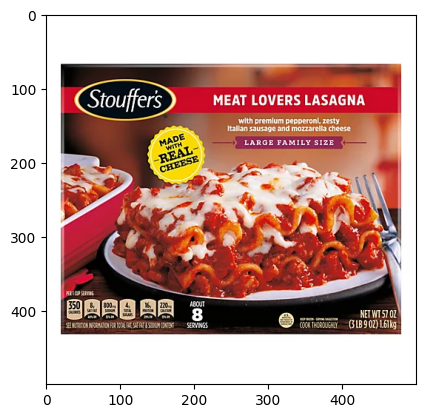

In [98]:
for img in os.listdir(not_pizza_dir):
    img = os.path.join(not_pizza_dir, img)
    img = plt.imread(img)
    plt.imshow(img)
    plt.show()
    break   # 잘 출력된다

오류 발생 : 오류 없는 파일명만 저장

In [99]:
# 오류 없는 이미지 파일명 리스트 생성
not_pizza_list, pizza_list = [], []

for img in os.listdir(not_pizza_dir):
    try:
        img = os.path.join(not_pizza_dir, img)
        img = plt.imread(img)
        not_pizza_list.append(img)
    except:
        continue
for img in os.listdir(pizza_dir):
    try:
        img = os.path.join(pizza_dir, img)
        img = plt.imread(img)
        pizza_list.append(img)
    except:
        continue

print(len(not_pizza_list), len(pizza_list))    # 945 945

945 945


피자가 너무 많다... 배율 조절 필수 (Weighted Random Sampler)
<hr>  

not_pizza_list에 없는 이미지 삭제

In [100]:
# not_pizza, pizza 폴더 내 이미지 삭제
# for img in os.listdir(not_pizza_dir):
#     if img not in os.listdir(not_pizza_dir):
#         os.remove(os.path.join(not_pizza_dir, img))
# for img in os.listdir(pizza_dir):
#     if img not in os.listdir(pizza_dir):
#         os.remove(os.path.join(pizza_dir, img))

# 무서우니까 주석처리

In [101]:
# 이미지 수 확인
print(len(os.listdir(not_pizza_dir)), len(os.listdir(pizza_dir)))    # 347 983 -> 326 945 -> 945 945

945 945


In [112]:
# 오류 확인
for img in os.listdir(not_pizza_dir):
    try:
        img = os.path.join(not_pizza_dir, img)
        img = plt.imread(img)
    except:
        print(img)
        continue
print('Done')

Done


평균 Shape으로 resize하기
1. 각 Shape의 평균 구하기
2. 평균 Shape으로 resize하기

In [103]:
# 1. 
Shapes = []
for img in not_pizza_list:
    Shapes.append(img.shape)
print(np.mean(Shapes, axis=0))  # [  3.  512.  512.]
print(np.min(Shapes, axis=0))  # [  3.  512.  512.]

[511.28677249 557.85291005   3.0021164 ]
[153 248   3]


In [104]:
Shapes = []
for img in pizza_list:
    Shapes.append(img.shape)
print(np.mean(Shapes, axis=0))  # [  3.  512.  512.]
print(np.min(Shapes, axis=0))  # [  3.  512.  512.]

[466.58835979 489.79153439   3.        ]
[127 287   3]


둘 평균으로 torch.Size([1, 256, 256])로 resize하기  
라자냐에 채널이 다른 게 있지만 1차원으로 진행 예정

In [166]:
# Shape 통일
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 전체 이미지 변환 : ImageFolder
total_dataset = ImageFolder(root=file_dir, transform=transform)

In [167]:
print(len(total_dataset))   # 1271
print(total_dataset.classes)    # ['not_pizza', 'pizza']

1890
['not_pizza', 'pizza']


shape 확인

In [169]:
for img, label in total_dataset:
    # print(img.shape, label)   # torch.Size([1, 256, 256]) 0
    if img.shape != (3, 256, 256):
        print(img.shape, label)
print('Done')

Done


깔끔, 모든 이미지는 1x256x256으로 resize됨

<hr>

라벨 길이 확인

In [170]:
# Check Label Length
label_list = []
img_count = 0
for img, label in total_dataset:
    img_count += 1
    label_list.append(label)
print(len(label_list))  # 1271
print(img_count)    # 1271
# 0과 1 개수
print(label_list.count(0), label_list.count(1))    # 326 945

1890
1890
945 945


Split Data : 8:1:1

In [171]:
# 2. Split Data
from torch.utils.data import random_split
ratios = [0.8, 0.1, 0.1]

train_dataset, valid_dataset, test_dataset = random_split(total_dataset, ratios, generator=torch.Generator().manual_seed(11))

print(len(train_dataset), len(valid_dataset), len(test_dataset))    # 1512 189 189

1512 189 189


데이터 로더 생성

In [172]:
# Weighted Random Sampler
# from torch.utils.data import WeightedRandomSampler

# class_sample_count = [label_list.count(0), label_list.count(1)]
# weights = 1 / torch.Tensor(class_sample_count)
# samples_weights = weights[label_list]
# samples_weights = samples_weights.double()
# print(samples_weights)
# print(samples_weights.shape)
# print(weights)
# sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

# => weight 제거해보기

In [173]:
# DataLoader : Batch Size = 32
train_loader = DataLoader(train_dataset, batch_size=32, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, drop_last=True)

print(len(train_loader), len(valid_loader), len(test_loader))    # 60 6 6

47 5 5


In [174]:
for (img, label) in train_loader:
    print(img.shape, label)
    break

torch.Size([32, 3, 256, 256]) tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1])


Model 불러오기 : Resnet18

In [199]:
# Model : ResNet18
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
print(num_ftrs) # 512
model.fc = nn.Linear(num_ftrs, 1)   # 512, 1
model

512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [200]:
# ResNet(
#   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (relu): ReLU(inplace=True)
#   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
#   (layer1): Sequential(
#     (0): BasicBlock(
#       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#     (1): BasicBlock(
#       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#   )
#   (layer2): Sequential(
#     (0): BasicBlock(
#       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (downsample): Sequential(
#         (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
#         (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       )
#     )
#     (1): BasicBlock(
#       (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#   )
#   (layer3): Sequential(
#     (0): BasicBlock(
#       (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (downsample): Sequential(
#         (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
#         (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       )
#     )
#     (1): BasicBlock(
#       (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#   )
#   (layer4): Sequential(
#     (0): BasicBlock(
#       (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (downsample): Sequential(
#         (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
#         (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       )
#     )
#     (1): BasicBlock(
#       (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#   )
#   (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
#   (fc): Linear(in_features=512, out_features=1, bias=True)
# )

In [201]:
# Resnet18 Feature module parameters : requires_grad=true -> False
for name, param in model.named_parameters():
    print(name, param.requires_grad, end=' ==> ')
    param.requires_grad = False
    print(param.requires_grad)
    
# Resnet18 Full Connected module parameters : requires_grad=false -> True
for name, param in model.fc.named_parameters():
    print(name, param.requires_grad, end=' ==> ')
    param.requires_grad = True
    print(param.requires_grad)

conv1.weight True ==> False
bn1.weight True ==> False
bn1.bias True ==> False
layer1.0.conv1.weight True ==> False
layer1.0.bn1.weight True ==> False
layer1.0.bn1.bias True ==> False
layer1.0.conv2.weight True ==> False
layer1.0.bn2.weight True ==> False
layer1.0.bn2.bias True ==> False
layer1.1.conv1.weight True ==> False
layer1.1.bn1.weight True ==> False
layer1.1.bn1.bias True ==> False
layer1.1.conv2.weight True ==> False
layer1.1.bn2.weight True ==> False
layer1.1.bn2.bias True ==> False
layer2.0.conv1.weight True ==> False
layer2.0.bn1.weight True ==> False
layer2.0.bn1.bias True ==> False
layer2.0.conv2.weight True ==> False
layer2.0.bn2.weight True ==> False
layer2.0.bn2.bias True ==> False
layer2.0.downsample.0.weight True ==> False
layer2.0.downsample.1.weight True ==> False
layer2.0.downsample.1.bias True ==> False
layer2.1.conv1.weight True ==> False
layer2.1.bn1.weight True ==> False
layer2.1.bn1.bias True ==> False
layer2.1.conv2.weight True ==> False
layer2.1.bn2.weight 

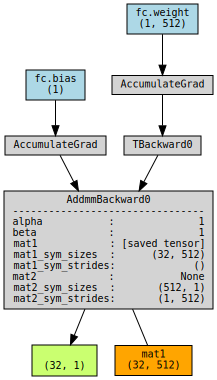

In [234]:
# makedot
from torchviz import make_dot

make_dot(model(torch.randn(32, 3, 256, 256)), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


학습

In [214]:
# for img, label in train_loader: 에서 오류 발생
# print(img.shape, label)
# break
# IndexError: list index out of range -> DataLoader에서 오류 발생
# : DataLoader에서 drop_last=True로 설정 -> 안됨
# 해결 : 

for img, label in train_loader:
    print(img.shape, label)
    break

torch.Size([32, 3, 256, 256]) tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1])


In [219]:
# 학습 준비
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
Epochs = 20

# 학습
for epoch in range(Epochs):
    model.train()
    for i, (imgs, labels) in enumerate(train_loader):
        
        preds = model(imgs)
        label = labels.unsqueeze(1).float()
        loss = criterion(preds, label)

        optimizer.zero_grad()   # gradient 초기화
        loss.backward()     # backward
        optimizer.step()    # weight update

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{Epochs}], Step [{i+1}/{len(train_loader)}], Loss : {loss.item()}')

    scheduler.step(loss.item())
    if scheduler.state_dict()['_last_lr'][0] < 1e-6:
        break

    model.eval()
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(valid_loader):
            
            preds = model(imgs)
            label = labels.unsqueeze(1).float()
            
            loss = criterion(preds, label)
            pred = torch.sigmoid(preds) > 0.5
            acc = multiclass_accuracy(pred, label, num_classes=3)
            
            print(f'Epoch [{epoch+1}/{Epochs}], Step [{i+1}/{len(valid_loader)}], Loss : {loss.item()}, Accuracy : {acc.item()}')


Epoch [1/18], Step [1/47], Loss : 0.06371390074491501
Epoch [1/18], Step [11/47], Loss : 0.06261422485113144
Epoch [1/18], Step [21/47], Loss : 0.23000255227088928
Epoch [1/18], Step [31/47], Loss : 0.16547510027885437
Epoch [1/18], Step [41/47], Loss : 0.17579510807991028
Epoch [1/18], Step [1/5], Loss : 0.3089878261089325, Accuracy : 0.9047619104385376
Epoch [1/18], Step [2/5], Loss : 0.21696564555168152, Accuracy : 0.8809523582458496
Epoch [1/18], Step [3/5], Loss : 0.06824938952922821, Accuracy : 0.9375
Epoch [1/18], Step [4/5], Loss : 0.11040397733449936, Accuracy : 0.9473683834075928
Epoch [1/18], Step [5/5], Loss : 0.31984639167785645, Accuracy : 0.8650793433189392
Epoch [2/18], Step [1/47], Loss : 0.05958922207355499
Epoch [2/18], Step [11/47], Loss : 0.06026998534798622
Epoch [2/18], Step [21/47], Loss : 0.23870421946048737
Epoch [2/18], Step [31/47], Loss : 0.15212176740169525
Epoch [2/18], Step [41/47], Loss : 0.15805305540561676
Epoch [2/18], Step [1/5], Loss : 0.3214680850

In [237]:
# Test
model.eval()
with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_loader):
        
        preds = model(imgs)
        label = labels.unsqueeze(1).float()
        
        loss = criterion(preds, label)
        pred = torch.sigmoid(preds) > 0.5
        acc = multiclass_accuracy(pred, label, num_classes=3)
        
        print(f'Step [{i+1}/{len(test_loader)}], Loss : {loss.item()}, Accuracy : {acc.item()}')

Step [1/5], Loss : 0.2757575809955597, Accuracy : 0.8730158805847168
Step [2/5], Loss : 0.39692285656929016, Accuracy : 0.8571428656578064
Step [3/5], Loss : 0.24392883479595184, Accuracy : 0.8500000238418579
Step [4/5], Loss : 0.16458618640899658, Accuracy : 0.9372549057006836
Step [5/5], Loss : 0.30034056305885315, Accuracy : 0.8947368860244751


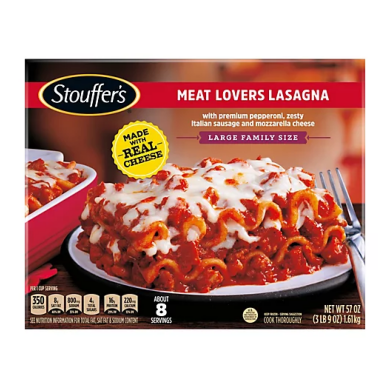

(500, 500, 3) <class 'numpy.ndarray'>


RuntimeError: shape '[1, 3, 256, 256]' is invalid for input of size 750000

In [251]:
# 이미지 넣어보기
new_image = plt.imread('../imgs/not_pizza/006410050.jpg')
plt.imshow(new_image)
plt.axis('off')
plt.show()

print(new_image.shape, type(new_image))
new_image = new_image.transpose(2, 0, 1)
new_image = torch.tensor(new_image).unsqueeze(0)
new_image = new_image / 255.0

print(new_image.shape)

Head 조절

학습 및 평가

In [ ]:
# 예측
model.eval()

수정

예측